# IMDB-5000 Dataset Analysis

### Objective: Given information about a movie, predict whether it is terrible, bad, good or great. This is a classification problem.

### Dataset

The IMDB-5000 dataset is of size (5043,28), meaning we have 5043 observations (datapoints) and 28 features (variables). The variables are things like:

* Director name
* Duration
* Names of top 3 actors in the movie
* Language

### Dataset Exploration

We print the shape of the dataset to understand how many variables we are working with. We print the colums to see what each variable is.

Since the 'score' is the dependent variable, it is useful to move this column to the end of the dataset.

We need to know which columns contain `NaN` values as these need to be dealt with.

Dataset shape:  (5043, 28)
Dataset columns:  Index(['color', 'director_name', 'num_critic_for_reviews', 'duration',
       'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name',
       'actor_1_facebook_likes', 'gross', 'genres', 'actor_1_name',
       'movie_title', 'num_voted_users', 'cast_total_facebook_likes',
       'actor_3_name', 'facenumber_in_poster', 'plot_keywords',
       'movie_imdb_link', 'num_user_for_reviews', 'language', 'country',
       'content_rating', 'budget', 'title_year', 'actor_2_facebook_likes',
       'imdb_score', 'aspect_ratio', 'movie_facebook_likes'],
      dtype='object')
Columns with NaN values:
new shape:  (5043, 27)


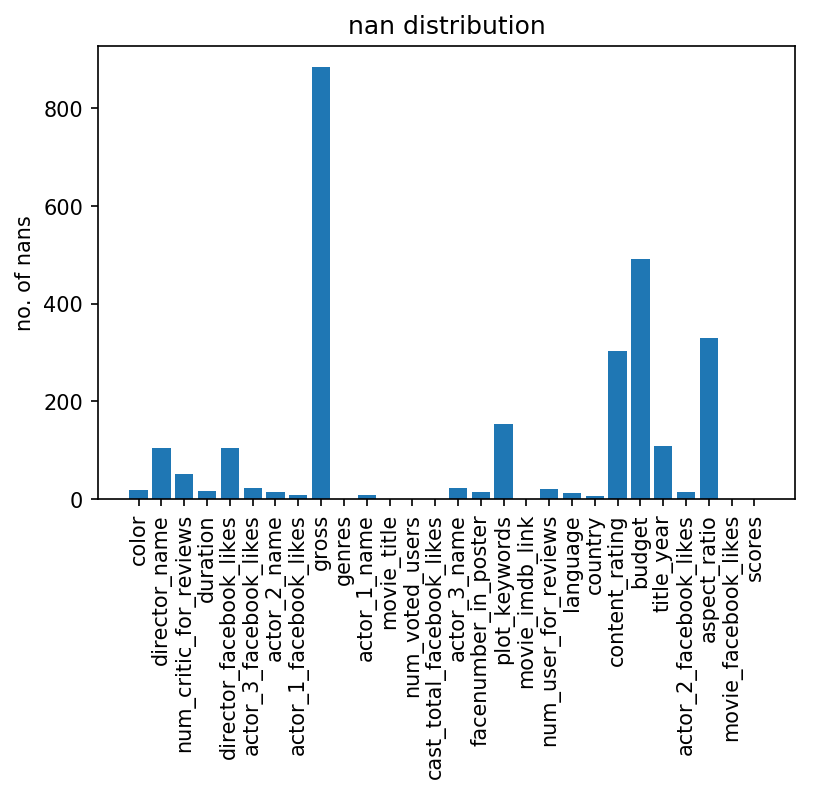

In [163]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# read in the dataset, print shape and column titles
dataset = pd.read_csv('movie_metadata.csv')
print("Dataset shape: ", dataset.shape)
print("Dataset columns: ", dataset.columns)

# move the dependent variable to the end of the dataframe
scores = list(dataset.iloc[:, -3].values)
dataset = dataset.drop(columns='imdb_score')
dataset['scores'] = scores

# count number of NaN values in the columns
print("Columns with NaN values:")
nans = []
all_nans = dataset.isna().sum()

for i in range(len(all_nans)):
    nans.append(all_nans[i])

# plot the number of NaN values per column
plt.figure(dpi=150)
plt.bar(list(dataset.columns), nans)
plt.xticks([i for i in range(len(list(dataset.columns)))], list(dataset.columns), rotation='vertical')
plt.title('nan distribution')
plt.ylabel('no. of nans')

dataset = dataset.drop(columns='movie_imdb_link')
# we remove all rows where there is no score
dataset = dataset.dropna(axis=0,subset=['scores'])
print("new shape: ", dataset.shape)

From this quick analysis we can see that gross has >10% of rows as NaN. We shall just remove this column instead of attempting to impute values. 

Some of these other columns can be reasonably imputed, such as budget and aspect ratio. For the former we can set NaNs to the average/median of the column and for aspect ratio we can set NaNs to the most frequent value of the column.

shape of data before:  (5043, 27)
shape of data after:  (4560, 26)


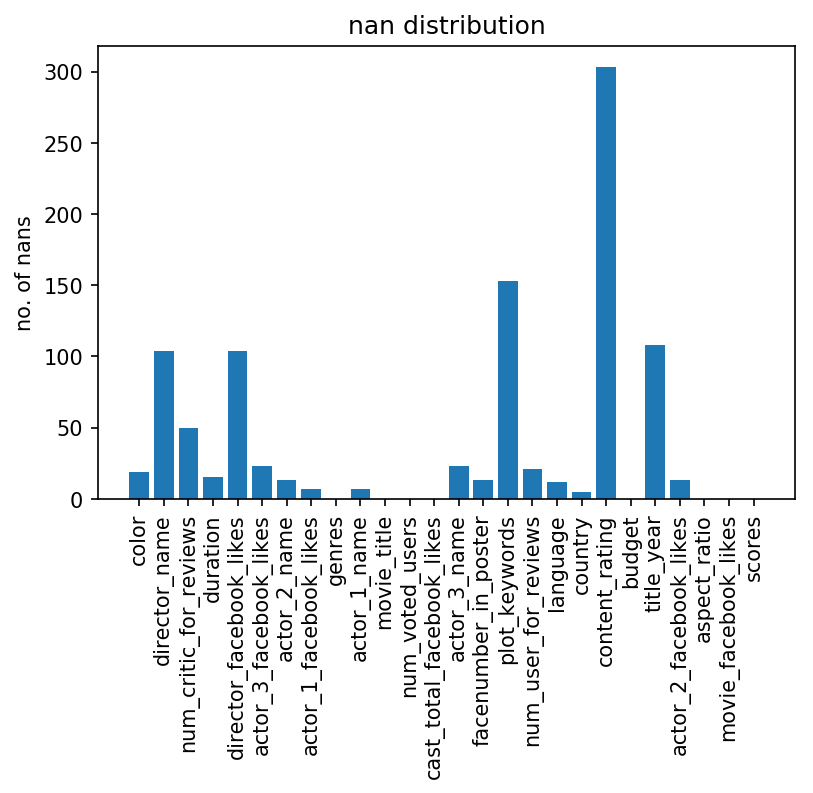

In [164]:
print("shape of data before: ", dataset.shape)

# Taking care of missing data
dataset = dataset.drop(columns='gross')

from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
imputer.fit(np.asarray(dataset['budget']).reshape(-1,1))
dataset['budget'] = imputer.transform(np.asarray(dataset['budget']).reshape(-1,1))

imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imputer.fit(np.asarray(dataset['aspect_ratio']).reshape(-1,1))
dataset['aspect_ratio'] = imputer.transform(np.asarray(dataset['aspect_ratio']).reshape(-1,1))

nans = []
all_nans = dataset.isna().sum()

for i in range(len(all_nans)):
    nans.append(all_nans[i])

# plot the number of NaN values per column
plt.figure(dpi=150)
plt.bar(list(dataset.columns), nans)
plt.xticks([i for i in range(len(list(dataset.columns)))], list(dataset.columns), rotation='vertical')
plt.title('nan distribution')
plt.ylabel('no. of nans')

dataset = dataset.dropna(axis=0)
print("shape of data after: ", dataset.shape)

Text(0, 0.5, 'no. of movies')

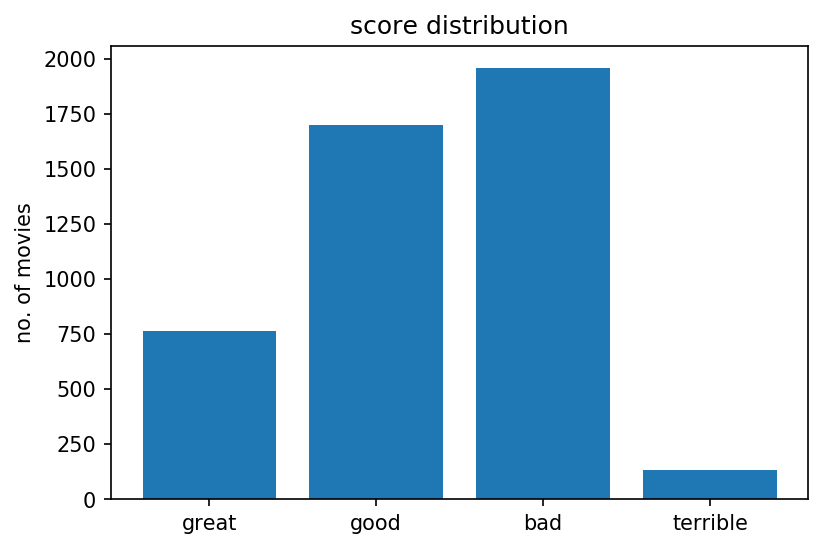

In [165]:
# put the score columns into categories
scores = list(dataset['scores'])
dataset.drop(columns='scores')
score_classes = []

for score in scores:
    if score >= 1.6 and score < 4.0:
        score_classes.append("terrible")
    elif score >= 4.0 and score < 6.5:
        score_classes.append("bad")
    elif score >= 6.5 and score < 7.5:
        score_classes.append("good")
    elif score >= 7.5 and score < 10.0:
        score_classes.append("great")
        
dataset['scores'] = score_classes

from collections import Counter
scores = Counter(list(dataset['scores']))

# plot the number of NaN values per column
plt.figure(dpi=150)
plt.bar(scores.keys(), scores.values())
plt.xticks([i for i in range(len(list(scores.keys())))], list(scores.keys()),)
plt.title('score distribution')
plt.ylabel('no. of movies')

### Now we split the dataset into the independent (X) and dependent variables (y)

#### X is a matrix with 27 columns, y is a vector

In [93]:
X = dataset.iloc[:,:-1]
y = dataset['scores'].values

print(X.shape)
print(y.shape)

(5043, 26)
(5043,)


### From the results a few cells above, we see that most of the columns contain `NaN` values. Our strategy for addressing this depends on the column. If the column is categorical, we will remove the row. If the column is numerical we will replace the `NaN` value with the mean of the column. For the dependent variable column, if there is a NaN we will remove the row.